# Multi-controlled Rx rotation gate decompositions

In [1]:
import numpy as np
import networkx as nx
import qiskit
from qiskit import Aer

import qcopt

#from NuOp import gates_numpy
#from NuOp import parallel_two_qubit_gate_decomposition as nuop

import gate_decomposition_numerics as gdn
import matplotlib.pyplot as plt

plt.rcParams.update({'font.family':'times'})
plt.rcParams["mathtext.fontset"] = "cm"

## Comparing gate decompositions on large graphs

In [2]:
def plot_d3_gate_counts(gate_count_dict, savefig=None):
    
    fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True, dpi=300)
    ls = {'CX':'-', 'CCX':'--', 'Qutrit':':'}
    color = {'SA-QAOA':'#0093d6', 'MA-QAOA':'#fc70be', 'DQVA':'#ffa600'}
    gateset = {'CX':'$\mathcal{S}^2_2$', 'CCX':'$\mathcal{S}^2_3$', 'Qutrit':'$\mathcal{S}^3_2$'}
    
    for alg, gate_counts in gate_count_dict.items():
        for native_gate in ['CX', 'CCX', 'Qutrit']:
            
            sizes, one_anc_decomps, n_anc_decomps = [], [], []
            for size, one_anc_decomp, n_anc_decomp in gate_counts[native_gate]:
                sizes.append(size)
                one_anc_decomps.append(one_anc_decomp)
                n_anc_decomps.append(n_anc_decomp)
                
            # Plot decomp with one ancilla
            ax[0].plot(sizes, [t[0] for t in one_anc_decomps], label=f'{alg}, {gateset[native_gate]}', ls=ls[native_gate], color=color[alg], lw=1.5)
            upper_std = [m+s for (m, s) in one_anc_decomps]
            lower_std = [max(m-s,0) for (m, s) in one_anc_decomps]
            #ax[0].fill_between(sizes, upper_std, lower_std, alpha=0.2, color=color[alg])
            
            # Plot decomp with n ancilla
            ax[1].plot(sizes, [t[0] for t in n_anc_decomps], label=f'{alg}, {gateset[native_gate]}', ls=ls[native_gate], color=color[alg], lw=1.5)
            upper_std = [m+s for (m, s) in n_anc_decomps]
            lower_std = [max(m-s,0) for (m, s) in n_anc_decomps]
            #ax[1].fill_between(sizes, upper_std, lower_std, alpha=0.2, color=color[alg])
    
    ax[0].legend(fontsize=7, loc='lower right', ncol=2)
    ax[0].set_yscale('log')
    ax[1].set_yscale('log')
    #ax[0].loglog()
    #ax[1].loglog()
    
    fs = 15
    ax[0].set_title('Barenco, 1 burnable ancilla', fontsize=fs)
    ax[1].set_title(r'Barenco, $n$ burnable ancilla', fontsize=fs)
    ax[0].set_ylabel('Entangling gate count', fontsize=fs)
    ax[0].set_xlabel(r'Graph size, $n$', fontsize=fs)
    ax[1].set_xlabel(r'Graph size, $n$', fontsize=fs)
    
    ax[0].tick_params(axis='both', labelsize=13)
    ax[1].tick_params(axis='both', labelsize=13)
    
    ax[0].grid(axis='y', which='both', alpha=0.5)
    ax[1].grid(axis='y', which='both', alpha=0.5)
    
    plt.tight_layout()
    
    if savefig:
        plt.savefig(savefig, bbox_inches='tight')


### Erdos-Renyi graphs - constant density

In [3]:
gate_count_dict = {'SA-QAOA':{'CX':[], 'CCX':[], 'Qutrit':[]}, 'MA-QAOA':{'CX':[], 'CCX':[], 'Qutrit':[]}, 'DQVA':{'CX':[], 'CCX':[], 'Qutrit':[]}}
sample_size = 100
avg_degree = 6
for size in [10, 15, 20, 30, 40, 60, 80, 120, 160, 240, 320, 640]:
    count = 1
    sample_graphs = []
    while count <= sample_size:
        sample_graphs.append(gdn.gen_erdos_renyi_graph(size, avg_degree))
        count += 1
    #G = gdn.gen_3_regular_graph(size)
    avg_density = []
    for G in sample_graphs:
        avg_density.append(np.mean([t[1] for t in G.degree()]))
    print(f"{size} node graphs, average density: {np.mean(avg_density):.2f}")
    
    for alg in gate_count_dict.keys():
        print(f'\t{alg}:')
        if alg == 'SA-QAOA':
            gate_counts = [gdn.sa_qaoa_gate_count(G, 10) for G in sample_graphs]
        elif alg == 'MA-QAOA':
            gate_counts = [gdn.ma_qaoa_gate_count(G) for G in sample_graphs]
        elif alg == 'DQVA':
            gate_counts = [gdn.dqva_gate_count(G, size // 2) for G in sample_graphs]

        for n, gateset in zip([1,2,3], ['CX', 'CCX', 'Qutrit']):
            if gateset == 'Qutrit':
                no_ancilla_count = [gdn.no_ancilla_qutrit(gate_count) for gate_count in gate_counts]
                
                gate_count_dict[alg][gateset].append(
                    (size,
                     (np.mean(no_ancilla_count), np.std(no_ancilla_count)),
                     (np.mean(no_ancilla_count), np.std(no_ancilla_count)),
                    )
                )
                print(f'\t\tWith native qutrits: {np.mean(no_ancilla_count):.2f} w/no ancilla')
            else:
                one_ancilla_count = [gdn.one_ancilla_barenco(gate_count, n) for gate_count in gate_counts]
                n_ancilla_count = [gdn.n_ancilla_barenco(gate_count, n) for gate_count in gate_counts]

                gate_count_dict[alg][gateset].append(
                    (size,
                     (np.mean(one_ancilla_count), np.std(one_ancilla_count)),
                     (np.mean(n_ancilla_count), np.std(n_ancilla_count)),
                    )
                )
                print(f'\t\tWith native C_{n}_X: {np.mean(one_ancilla_count):.2f} w/one ancilla, {np.mean(n_ancilla_count):.2f} w/n ancilla')

10 node graphs, average density: 6.06
	SA-QAOA:
		With native C_1_X: 8684.40 w/one ancilla, 3630.40 w/n ancilla
		With native C_2_X: 2483.60 w/one ancilla, 1011.60 w/n ancilla
		With native qutrits: 3328.40 w/no ancilla
	MA-QAOA:
		With native C_1_X: 868.44 w/one ancilla, 363.04 w/n ancilla
		With native C_2_X: 248.36 w/one ancilla, 101.16 w/n ancilla
		With native qutrits: 332.84 w/no ancilla
	DQVA:
		With native C_1_X: 432.96 w/one ancilla, 181.38 w/n ancilla
		With native C_2_X: 123.88 w/one ancilla, 50.50 w/n ancilla
		With native qutrits: 166.24 w/no ancilla
15 node graphs, average density: 5.96
	SA-QAOA:
		With native C_1_X: 12532.20 w/one ancilla, 5337.80 w/n ancilla
		With native C_2_X: 3672.40 w/one ancilla, 1488.00 w/n ancilla
		With native qutrits: 4912.80 w/no ancilla
	MA-QAOA:
		With native C_1_X: 1253.22 w/one ancilla, 533.78 w/n ancilla
		With native C_2_X: 367.24 w/one ancilla, 148.80 w/n ancilla
		With native qutrits: 491.28 w/no ancilla
	DQVA:
		With native C_1_X: 595

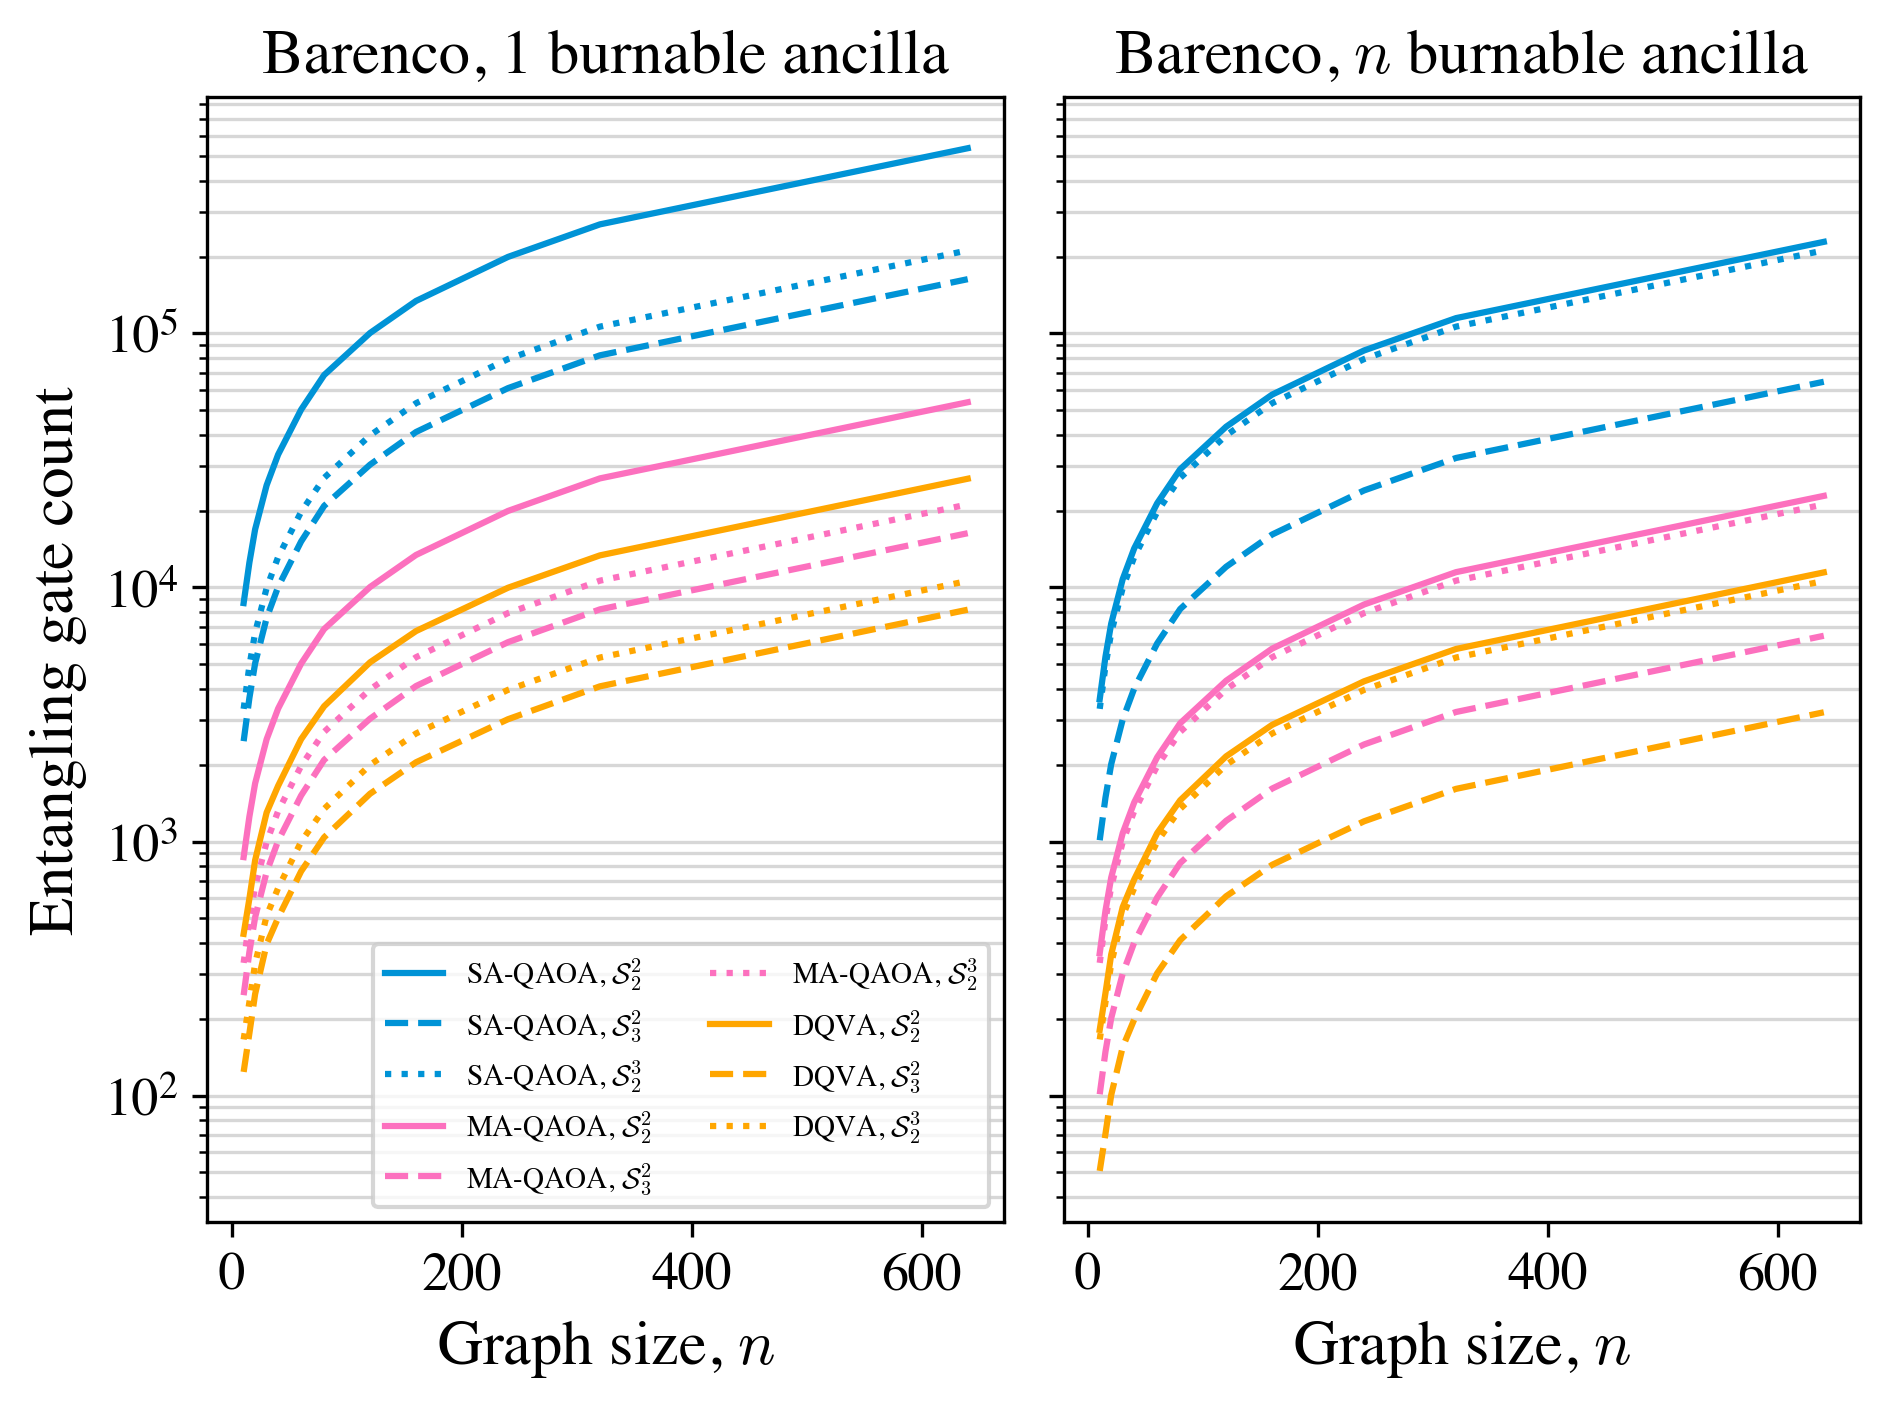

In [4]:
plot_d3_gate_counts(gate_count_dict, savefig='figures/barenco_gate_counts_final.pdf')

### Erdos-Renyi graphs - constant edge probability

In [3]:
gate_count_dict = {'SA-QAOA':{'CX':[], 'CCX':[]}, 'MA-QAOA':{'CX':[], 'CCX':[]}, 'DQVA':{'CX':[], 'CCX':[]}}
sample_size = 100
edge_probability = 0.1
for size in [10, 15, 20, 30, 40, 60, 80, 120, 160, 240, 320, 640]:
    count = 1
    sample_graphs = []
    while count <= sample_size:
        sample_graphs.append(gdn.gen_erdos_renyi_graph(size, edge_probability * (size - 1)))
        count += 1

    avg_density = []
    for G in sample_graphs:
        avg_density.append(np.mean([t[1] for t in G.degree()]))
    print(f"{size} node graphs, average density: {np.mean(avg_density):.2f}")
    
    for alg in gate_count_dict.keys():
        print(f'\t{alg}:')
        if alg == 'SA-QAOA':
            gate_counts = [gdn.sa_qaoa_gate_count(G, 10) for G in sample_graphs]
        elif alg == 'MA-QAOA':
            gate_counts = [gdn.ma_qaoa_gate_count(G) for G in sample_graphs]
        elif alg == 'DQVA':
            gate_counts = [gdn.dqva_gate_count(G, size // 2) for G in sample_graphs]

        for n, gateset in zip([1,2], ['CX', 'CCX']):
            one_ancilla_count = [gdn.one_ancilla_barenco(gate_count, n) for gate_count in gate_counts]
            n_ancilla_count = [gdn.n_ancilla_barenco(gate_count, n) for gate_count in gate_counts]

            gate_count_dict[alg][gateset].append(
                (size,
                 (np.mean(one_ancilla_count), np.std(one_ancilla_count)),
                 (np.mean(n_ancilla_count), np.std(n_ancilla_count)),
                )
            )

            print(f'\t\tWith native C_{n}_X: {np.mean(one_ancilla_count):.2f} w/one ancilla, {np.mean(n_ancilla_count):.2f} w/n ancilla')

10 node graphs, average density: 2.06
	SA-QAOA:
		With native C_1_X: 1049.60 w/one ancilla, 879.60 w/n ancilla
		With native C_2_X: 318.00 w/one ancilla, 278.60 w/n ancilla
	MA-QAOA:
		With native C_1_X: 104.96 w/one ancilla, 87.96 w/n ancilla
		With native C_2_X: 31.80 w/one ancilla, 27.86 w/n ancilla
	DQVA:
		With native C_1_X: 53.88 w/one ancilla, 44.58 w/n ancilla
		With native C_2_X: 16.26 w/one ancilla, 14.14 w/n ancilla
15 node graphs, average density: 2.26
	SA-QAOA:
		With native C_1_X: 2018.40 w/one ancilla, 1553.00 w/n ancilla
		With native C_2_X: 579.40 w/one ancilla, 466.20 w/n ancilla
	MA-QAOA:
		With native C_1_X: 201.84 w/one ancilla, 155.30 w/n ancilla
		With native C_2_X: 57.94 w/one ancilla, 46.62 w/n ancilla
	DQVA:
		With native C_1_X: 95.28 w/one ancilla, 72.16 w/n ancilla
		With native C_2_X: 27.38 w/one ancilla, 21.72 w/n ancilla
20 node graphs, average density: 2.50
	SA-QAOA:
		With native C_1_X: 3378.80 w/one ancilla, 2427.80 w/n ancilla
		With native C_2_X: 938

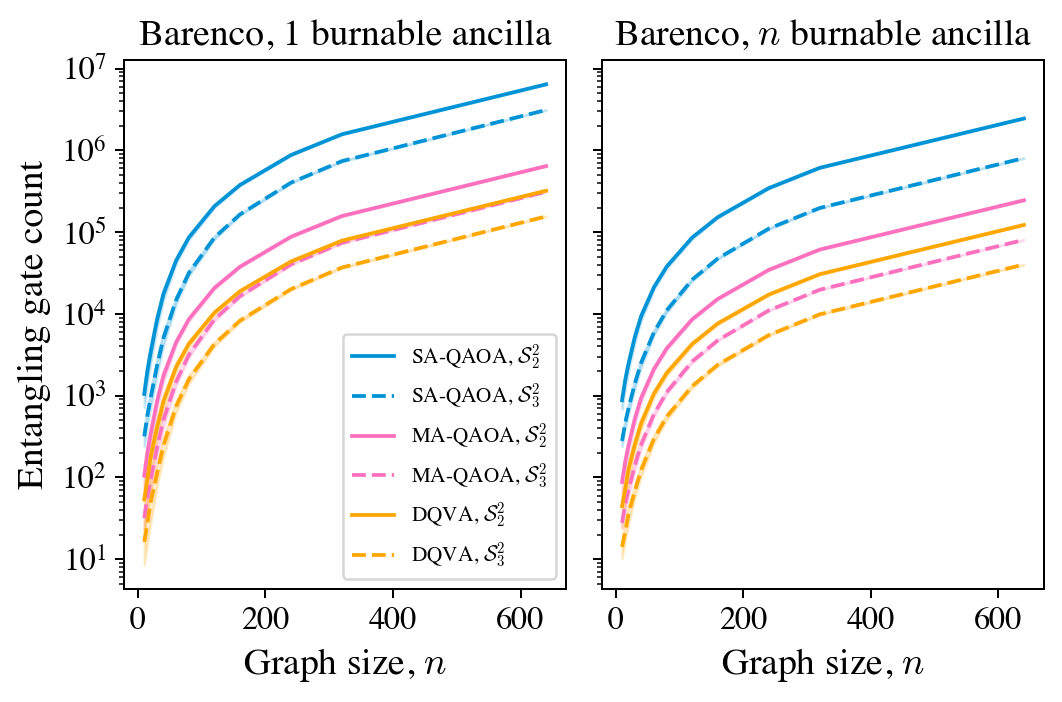

In [4]:
plot_d3_gate_counts(gate_count_dict, savefig=None)

### d-regular graphs

In [145]:
gate_count_dict = {'SA-QAOA':{'CX':[], 'CCX':[]}, 'MA-QAOA':{'CX':[], 'CCX':[]}, 'DQVA':{'CX':[], 'CCX':[]}}
sample_size = 100
avg_degree = 6
size = 100
for degree in [3, 4, 5, 6, 7, 8, 9, 10]:
    count = 1
    sample_graphs = []
    while count <= sample_size:
        sample_graphs.append(nx.random_regular_graph(degree, size))
        count += 1

    avg_density = []
    for G in sample_graphs:
        avg_density.append(np.mean([t[1] for t in G.degree()]))
    print(f"{size} node graphs, average density: {np.mean(avg_density):.2f}")
    
    for alg in gate_count_dict.keys():
        print(f'\t{alg}:')
        if alg == 'SA-QAOA':
            gate_counts = [gdn.sa_qaoa_gate_count(G, 10) for G in sample_graphs]
        elif alg == 'MA-QAOA':
            gate_counts = [gdn.ma_qaoa_gate_count(G) for G in sample_graphs]
        elif alg == 'DQVA':
            gate_counts = [gdn.dqva_gate_count(G, size // 2) for G in sample_graphs]

        for n, gateset in zip([1,2], ['CX', 'CCX']):
            one_ancilla_count = [gdn.one_ancilla_barenco(gate_count, n) for gate_count in gate_counts]
            n_ancilla_count = [gdn.n_ancilla_barenco(gate_count, n) for gate_count in gate_counts]

            gate_count_dict[alg][gateset].append(
                (degree,
                 (np.mean(one_ancilla_count), np.std(one_ancilla_count)),
                 (np.mean(n_ancilla_count), np.std(n_ancilla_count)),
                )
            )

            print(f'\t\tWith native C_{n}_X: {np.mean(one_ancilla_count):.2f} w/one ancilla, {np.mean(n_ancilla_count):.2f} w/n ancilla')

100 node graphs, average density: 3.00
	SA-QAOA:
		With native C_1_X: 18000.00 w/one ancilla, 18000.00 w/n ancilla
		With native C_2_X: 4000.00 w/one ancilla, 4000.00 w/n ancilla
	MA-QAOA:
		With native C_1_X: 1800.00 w/one ancilla, 1800.00 w/n ancilla
		With native C_2_X: 400.00 w/one ancilla, 400.00 w/n ancilla
	DQVA:
		With native C_1_X: 900.00 w/one ancilla, 900.00 w/n ancilla
		With native C_2_X: 200.00 w/one ancilla, 200.00 w/n ancilla
100 node graphs, average density: 4.00
	SA-QAOA:
		With native C_1_X: 42000.00 w/one ancilla, 24000.00 w/n ancilla
		With native C_2_X: 10000.00 w/one ancilla, 6000.00 w/n ancilla
	MA-QAOA:
		With native C_1_X: 4200.00 w/one ancilla, 2400.00 w/n ancilla
		With native C_2_X: 1000.00 w/one ancilla, 600.00 w/n ancilla
	DQVA:
		With native C_1_X: 2100.00 w/one ancilla, 1200.00 w/n ancilla
		With native C_2_X: 500.00 w/one ancilla, 300.00 w/n ancilla
100 node graphs, average density: 5.00
	SA-QAOA:
		With native C_1_X: 62000.00 w/one ancilla, 30000.00 w

In [146]:
def plot_degree_gate_counts(gate_count_dict, savefig=None):
    
    fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True, dpi=180)
    ls = {'CX':'-', 'CCX':'--'}
    color = {'SA-QAOA':'tab:blue', 'MA-QAOA':'tab:orange', 'DQVA':'tab:green'}
    gateset = {'CX':'$\mathcal{S}^2_2$', 'CCX':'$\mathcal{S}^2_3$'}
    
    for alg, gate_counts in gate_count_dict.items():
        for native_gate in ['CX', 'CCX']:
            
            degrees, one_anc_decomps, n_anc_decomps = [], [], []
            for degree, one_anc_decomp, n_anc_decomp in gate_counts[native_gate]:
                degrees.append(degree)
                one_anc_decomps.append(one_anc_decomp)
                n_anc_decomps.append(n_anc_decomp)
                
            # Plot decomp with one ancilla
            ax[0].plot(degrees, [t[0] for t in one_anc_decomps], label=f'{alg}, {gateset[native_gate]}', ls=ls[native_gate], color=color[alg], lw=1.5)
            upper_std = [m+s for (m, s) in one_anc_decomps]
            lower_std = [max(m-s,0) for (m, s) in one_anc_decomps]
            ax[0].fill_between(degrees, upper_std, lower_std, alpha=0.2, color=color[alg])
            
            # Plot decomp with n ancilla
            ax[1].plot(degrees, [t[0] for t in n_anc_decomps], label=f'{alg}, {gateset[native_gate]}', ls=ls[native_gate], color=color[alg], lw=1.5)
            upper_std = [m+s for (m, s) in n_anc_decomps]
            lower_std = [max(m-s,0) for (m, s) in n_anc_decomps]
            ax[1].fill_between(degrees, upper_std, lower_std, alpha=0.2, color=color[alg])
    
    ax[0].legend(fontsize=8.5, loc='lower right', ncol=1)
    ax[0].set_yscale('log')
    ax[1].set_yscale('log')
    #ax[0].loglog()
    #ax[1].loglog()
    
    fs = 15
    ax[0].set_title('Barenco, 1 burnable ancilla', fontsize=fs)
    ax[1].set_title(r'Barenco, $n$ burnable ancilla', fontsize=fs)
    ax[0].set_ylabel('Entangling gate count', fontsize=fs)
    ax[0].set_xlabel(r'Graph degree, $n$', fontsize=fs)
    ax[1].set_xlabel(r'Graph degree, $n$', fontsize=fs)
    
    ax[0].tick_params(axis='both', labelsize=13)
    ax[1].tick_params(axis='both', labelsize=13)
    
    #ax[0].grid()
    #ax[1].grid()
    
    plt.tight_layout()
    
    if savefig:
        plt.savefig(savefig, bbox_inches='tight')



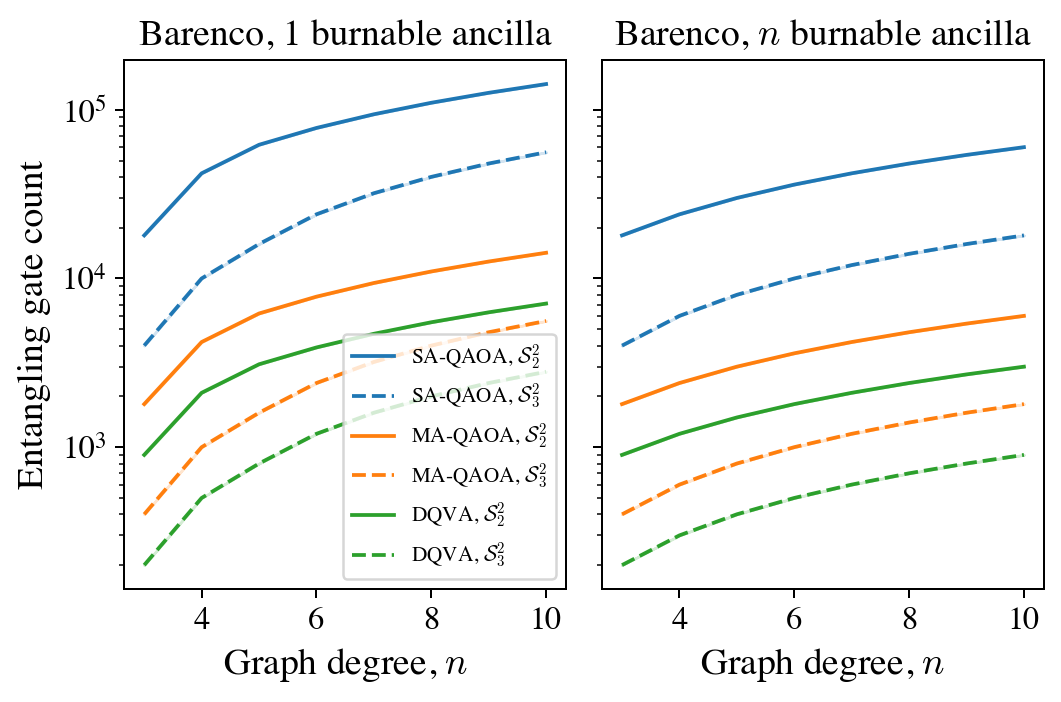

In [147]:
plot_degree_gate_counts(gate_count_dict, savefig=None)

## Decomposition fidelity score

In [5]:
for n in range(1,6):
    one_2 = gdn.one_ancilla_barenco_basis_counts({f'c_{n}_Rx':1}, 1)
    one_3 = gdn.one_ancilla_barenco_basis_counts({f'c_{n}_Rx':1}, 2)
    n_2 = gdn.n_ancilla_barenco_basis_counts({f'c_{n}_Rx':1}, 1)
    n_3 = gdn.n_ancilla_barenco_basis_counts({f'c_{n}_Rx':1}, 2)
    qutrit = gdn.no_ancilla_qutrit_basis_counts({f'c_{n}_Rx':1})
    print(f'n = {n}: {one_2}  |  {one_3}  |  {n_2}  |  {n_3}  | {qutrit}')

n = 1: [2]  |  [2, 0]  |  [2]  |  [2, 0]  | [2]
n = 2: [6]  |  [0, 2]  |  [6]  |  [0, 2]  | [4]
n = 3: [18]  |  [0, 4]  |  [18]  |  [0, 4]  | [14]
n = 4: [42]  |  [0, 10]  |  [24]  |  [0, 6]  | [16]
n = 5: [72]  |  [0, 16]  |  [30]  |  [0, 8]  | [26]


In [6]:
def compute_dfs(fidelities, basis_gates):
    dfs_vals = []
    for fidelity in fidelities:
        temp_dfs = []
        for gate_counts in basis_gates:
            #print(f'{fidelity} ^ {sum(gate_counts)} = {fidelity ** sum(gate_counts)}')
            temp_dfs.append(-sum(gate_counts) * np.log(fidelity))
                
        dfs_vals.append((np.mean(temp_dfs), np.std(temp_dfs)))
    return dfs_vals

dfs_dict = {'SA-QAOA':{'CX':None, 'CCX':None, 'Qutrit':None}, 'MA-QAOA':{'CX':None, 'CCX':None, 'Qutrit':None}, 'DQVA':{'CX':None, 'CCX':None, 'Qutrit':None}}
sample_size = 100
avg_degree = 6
size = 100
sample_graphs = [gdn.gen_erdos_renyi_graph(size, avg_degree) for _ in range(sample_size)]
avg_density = []
for G in sample_graphs:
    avg_density.append(np.mean([t[1] for t in G.degree()]))
print(f"{size} node graphs, average density: {np.mean(avg_density):.2f}")

fidelities = np.arange(0.96, 0.9999, 0.0005)

for alg in gate_count_dict.keys():
    print(f'\t{alg}:')
    if alg == 'SA-QAOA':
        gate_counts = [gdn.sa_qaoa_gate_count(G, 10) for G in sample_graphs]
    elif alg == 'MA-QAOA':
        gate_counts = [gdn.ma_qaoa_gate_count(G) for G in sample_graphs]
    elif alg == 'DQVA':
        gate_counts = [gdn.dqva_gate_count(G, size // 2) for G in sample_graphs]

    for n, gateset in zip([1,2,3], ['CX', 'CCX', 'Qutrit']):
        print('\t'+gateset)
        if gateset == 'Qutrit':
            basis_gates = [gdn.no_ancilla_qutrit_basis_counts(gate_count) for gate_count in gate_counts]
            qutrit_dfs = compute_dfs(fidelities, basis_gates)
            dfs_dict[alg][gateset] = (fidelities, qutrit_dfs, qutrit_dfs)
            
        else:
            one_basis_gates = [gdn.one_ancilla_barenco_basis_counts(gate_count, n) for gate_count in gate_counts]
            one_anc_dfs = compute_dfs(fidelities, one_basis_gates)
            
            n_basis_gates = [gdn.n_ancilla_barenco_basis_counts(gate_count, n) for gate_count in gate_counts]
            n_anc_dfs = compute_dfs(fidelities, n_basis_gates)
            
            dfs_dict[alg][gateset] = (fidelities, one_anc_dfs, n_anc_dfs)

100 node graphs, average density: 6.01
	SA-QAOA:
	CX
	CCX
	Qutrit
	MA-QAOA:
	CX
	CCX
	Qutrit
	DQVA:
	CX
	CCX
	Qutrit


In [11]:
def plot_dfs(dfs_dict, savefig=None):
    
    fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True, dpi=300, figsize=[9,5])
    ls = {'CX':'-', 'CCX':'--', 'Qutrit':':'}
    color = {'SA-QAOA':'#0093d6', 'MA-QAOA':'#fc70be', 'DQVA':'#ffa600'}
    gateset = {'CX':'$\mathcal{S}^2_2$', 'CCX':'$\mathcal{S}^2_3$', 'Qutrit':'$\mathcal{S}^3_2$'}
    
    for alg, dfs_values in dfs_dict.items():
        for native_gate in ['CX', 'CCX', 'Qutrit']:
            
            fidelities, one_anc_dfs, n_anc_dfs = dfs_values[native_gate]
                
            # Plot dfs with one ancilla
            ax[0].plot(fidelities, [t[0] for t in one_anc_dfs], label=f'{alg}, {gateset[native_gate]}', ls=ls[native_gate], color=color[alg], lw=1.5)
            #upper_std = [m+s for (m, s) in one_anc_dfs]
            #lower_std = [max(m-s,0) for (m, s) in one_anc_dfs]
            #ax[0].fill_between(fidelities, upper_std, lower_std, alpha=0.2, color=color[alg])
            
            # Plot dfs with n ancilla
            ax[1].plot(fidelities, [t[0] for t in n_anc_dfs], label=f'{alg}, {gateset[native_gate]}', ls=ls[native_gate], color=color[alg], lw=1.5)
            #upper_std = [m+s for (m, s) in n_anc_dfs]
            #lower_std = [max(m-s,0) for (m, s) in n_anc_dfs]
            #ax[1].fill_between(fidelities, upper_std, lower_std, alpha=0.2, color=color[alg])
    
    ax[0].legend(fontsize=10, loc='lower left', ncol=2)
    ax[0].set_yscale('log')
    ax[1].set_yscale('log')
    #ax[0].loglog()
    #ax[1].loglog()
    
    fs = 18
    ax[0].set_title('Barenco, 1 burnable ancilla', fontsize=fs)
    ax[1].set_title(r'Barenco, $n$ burnable ancilla', fontsize=fs)
    ax[0].set_ylabel('Gate decomposition cost', fontsize=fs)
    ax[0].set_xlabel(r'Entangling Gate Fidelity', fontsize=fs)
    ax[1].set_xlabel(r'Entangling Gate Fidelity', fontsize=fs)
    
    ax[0].tick_params(axis='both', labelsize=15)
    ax[1].tick_params(axis='both', labelsize=15)
    
    ax[0].grid(axis='y', which='both', alpha=0.5)
    ax[1].grid(axis='y', which='both', alpha=0.5)
    
    plt.tight_layout()
    
    if savefig:
        plt.savefig(savefig, bbox_inches='tight')

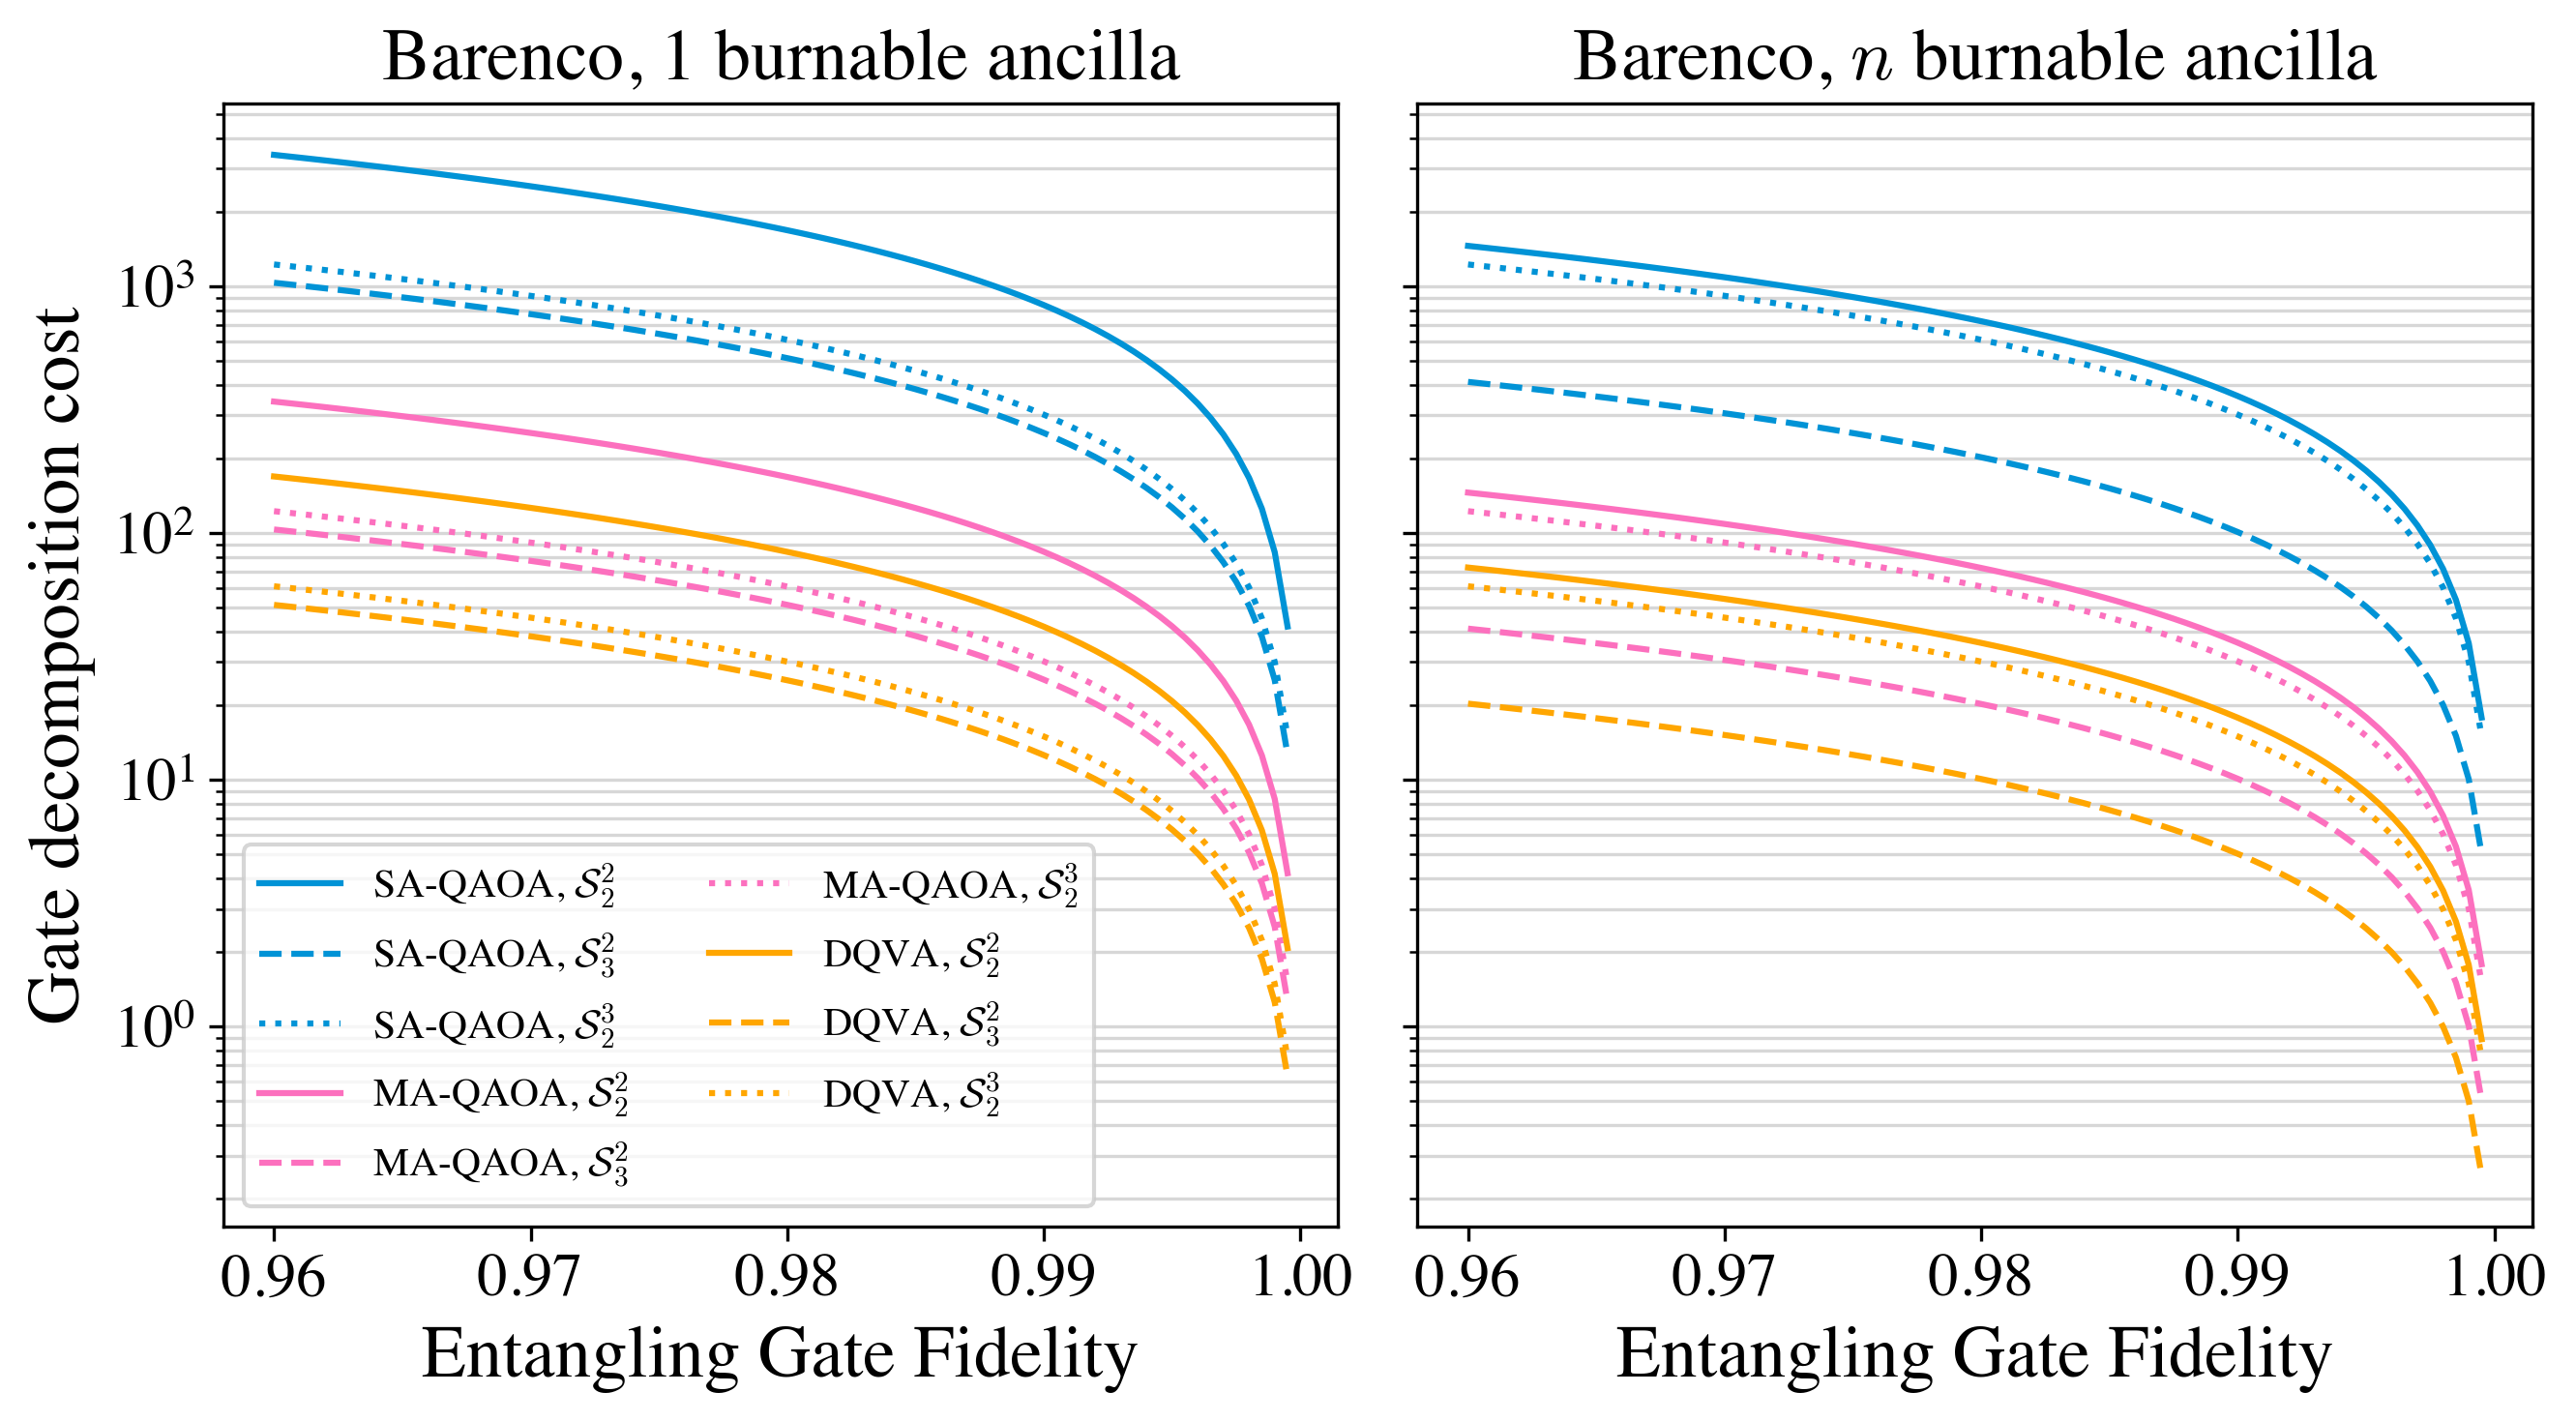

In [12]:
plot_dfs(dfs_dict, savefig='figures/decomposition_infidelity_score_final.pdf')

## No ancilla comparison

In [117]:
theta = np.pi / 2 
qubits = qiskit.QuantumRegister(4)
ancilla_circ = qiskit.QuantumCircuit(qubits)
ancilla_circ.mcrx(theta, qubits[:3], qubits[3])
ancilla_circ.measure_all()
ancilla_circ.draw(fold=-1)

┌───┐                      ┌───┐                     ┌───┐                      ┌───┐                      ░ ┌─┐         
q9543_0: ──────────────────────────────────────────────────────────────────────────┤ X ├──────────■───────────┤ X ├──────────■──────────┤ X ├──────────■───────────┤ X ├──────────■───────────░─┤M├─────────
                              ┌───┐                      ┌───┐                     └─┬─┘          │           └─┬─┘          │          └─┬─┘          │           └─┬─┘          │           ░ └╥┘┌─┐      
q9543_1: ─────────────────────┤ X ├──────────■───────────┤ X ├──────────■────────────■────────────┼─────────────┼────────────┼────────────■────────────┼─────────────┼────────────┼───────────░──╫─┤M├──────
                              └─┬─┘          │           └─┬─┘          │                         │             │            │                         │             │            │           ░  ║ └╥┘┌─┐   
q9543_2: ──────────■────────────■────────────┼─────────────■────────────┼─────────────────────────┼─────────────■────────────┼─────────────────────────┼─────────────■────────────┼───────────░──╫──╫─┤M├───
         ┌─────────┴─────────┐     ┌─────────┴──────────┐     ┌─────────┴─────────┐     ┌─────────┴──────────┐     ┌─────────┴─────────┐     ┌─────────┴──────────┐     ┌─────────┴─────────┐ ░  ║  ║ └╥┘┌─┐
q9543_3: ┤ U(π/8,-π/2,π/2,0) ├─────┤ U(-π/8,-π/2,π/2,0) ├─────┤ U(π/8,-π/2,π/2,0) ├─────┤ U(-π/8,-π/2,π/2,0) ├─────┤ U(π/8,-π/2,π/2,0) ├─────┤ U(-π/8,-π/2,π/2,0) ├─────┤ U(π/8,-π/2,π/2,0) ├─░──╫──╫──╫─┤M├
         └───────────────────┘     └────────────────────┘     └───────────────────┘     └────────────────────┘     └───────────────────┘     └────────────────────┘     └───────────────────┘ ░  ║  ║  ║ └╥┘
 meas: 4/════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════╩══╩══╩══╩═
                                                                                                                                                                                                 0  1  2  3

In [118]:
new_circ = qiskit.QuantumCircuit(qubits)
new_circ.rz(np.pi/2, qubits[3])
new_circ.ry(theta/2, qubits[3])
new_circ.mct(qubits[:3], qubits[3])
new_circ.ry(-theta/2, qubits[3])
new_circ.mct(qubits[:3], qubits[3])
new_circ.rz(-np.pi/2, qubits[3])
new_circ.measure_all()
new_circ.draw(fold=-1)

░ ┌─┐         
q9543_0: ────────────────────────■────────────────■───────────────░─┤M├─────────
                                 │                │               ░ └╥┘┌─┐      
q9543_1: ────────────────────────■────────────────■───────────────░──╫─┤M├──────
                                 │                │               ░  ║ └╥┘┌─┐   
q9543_2: ────────────────────────■────────────────■───────────────░──╫──╫─┤M├───
         ┌─────────┐┌─────────┐┌─┴─┐┌──────────┐┌─┴─┐┌──────────┐ ░  ║  ║ └╥┘┌─┐
q9543_3: ┤ Rz(π/2) ├┤ Ry(π/4) ├┤ X ├┤ Ry(-π/4) ├┤ X ├┤ Rz(-π/2) ├─░──╫──╫──╫─┤M├
         └─────────┘└─────────┘└───┘└──────────┘└───┘└──────────┘ ░  ║  ║  ║ └╥┘
 meas: 4/════════════════════════════════════════════════════════════╩══╩══╩══╩═
                                                                     0  1  2  3

In [85]:
def eval_basis_state(basis_state, circuit):
    qubits = circuit.qubits
    init_circ = qiskit.QuantumCircuit(qubits)
    for i, bit in enumerate(basis_state):
        if bit == '1':
            init_circ.x(qubits[i])
    
    result = qiskit.execute(init_circ + circuit, Aer.aer.get_backend('aer_simulator'), shots=100).result()
    
    return result.get_counts()

In [95]:
print('Basis states are ordered: q3q2q1q0')
print('Basis state, Old Circ, New Circ')
print('-'*31)
for basis_idx in range(int(2**4)):
    basis_state = f'{basis_idx:04b}'
    old_output = list(eval_basis_state(''.join(reversed(list(basis_state))), ancilla_circ).keys())
    new_output = list(eval_basis_state(''.join(reversed(list(basis_state))), new_circ).keys())
    print(' '*4, basis_state, ' '*4, *old_output, ' '*4, *new_output)

Basis states are ordered: q3q2q1q0
Basis state, Old Circ, New Circ
-------------------------------
     0000      0000      0000
     0001      0001      0001
     0010      0010      0010
     0011      0011      0011
     0100      0100      0100
     0101      0101      0101
     0110      0110      0110
     0111      1111      1111
     1000      1000      1000
     1001      1001      1001
     1010      1010      1010
     1011      1011      1011
     1100      1100      1100
     1101      1101      1101
     1110      1110      1110
     1111      0111      0111


In [119]:
ancilla_circ.remove_final_measurements()
new_circ.remove_final_measurements()

old_job = qiskit.execute(ancilla_circ, Aer.aer.get_backend('unitary_simulator'))
old_result = old_job.result()
old_unitary = old_result.get_unitary(ancilla_circ, decimals=3)

new_job = qiskit.execute(new_circ, Aer.aer.get_backend('unitary_simulator'))
new_result = new_job.result()
new_unitary = new_result.get_unitary(new_circ, decimals=3)

(old_unitary == new_unitary).all()

True

## MCRX gate

In [120]:
from qiskit.circuit import ControlledGate
from qiskit.circuit.library.standard_gates import RXGate

In [124]:
mcrx = ControlledGate('mcrx', 4, [2 * np.pi],
                      num_ctrl_qubits=3,
                      ctrl_state='000',
                      base_gate=RXGate(2 * np.pi))

In [126]:
qubits = qiskit.QuantumRegister(4)
circ = qiskit.QuantumCircuit(qubits)
circ.append(mcrx, qubits)
circ.draw()

q9570_0: ────o─────
             │     
q9570_1: ────o─────
             │     
q9570_2: ────o─────
         ┌───┴────┐
q9570_3: ┤ Rx(2π) ├
         └────────┘

### Test new gate and no-ancilla circuit

#### DQVA

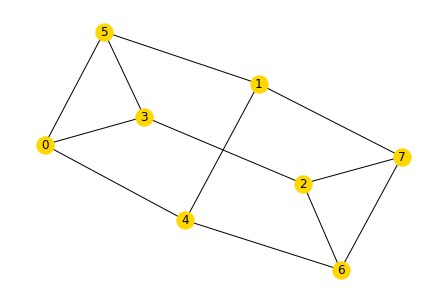

In [3]:
G = qcopt.graph_funcs.graph_from_file('benchmark_graphs/N8_d3_graphs/G1.txt')
nx.draw_spring(G, with_labels=True, node_color='gold')

In [5]:
new_circ = qcopt.dqva.gen_dqva(G, params=[1 for _ in range(G.number_of_nodes()+1)], barriers=2, decompose_toffoli=0)
new_circ.draw(fold=-1)

░           ░           ░           ░           ░           ░           ░ ┌───────┐ ░           ░  ░ ┌───────┐ ░  ░ 
q_0: ─░───────────░───────────░───────────░─────o─────░───────────░─────o─────░─┤ Rx(2) ├─░─────o─────░──░─┤ Rz(2) ├─░──░─
      ░           ░           ░           ░     │     ░ ┌───────┐ ░     │     ░ └───┬───┘ ░     │     ░  ░ ├───────┤ ░  ░ 
q_1: ─░───────────░─────o─────░───────────░─────┼─────░─┤ Rx(2) ├─░─────o─────░─────┼─────░─────o─────░──░─┤ Rz(2) ├─░──░─
      ░ ┌───────┐ ░     │     ░           ░     │     ░ └───┬───┘ ░     │     ░     │     ░     │     ░  ░ ├───────┤ ░  ░ 
q_2: ─░─┤ Rx(2) ├─░─────o─────░─────o─────░─────o─────░─────┼─────░─────┼─────░─────┼─────░─────┼─────░──░─┤ Rz(2) ├─░──░─
      ░ └───┬───┘ ░     │     ░     │     ░ ┌───┴───┐ ░     │     ░     │     ░     │     ░     │     ░  ░ ├───────┤ ░  ░ 
q_3: ─░─────o─────░─────┼─────░─────┼─────░─┤ Rx(2) ├─░─────┼─────░─────┼─────░─────o─────░─────o─────░──░─┤ Rz(2) ├─░──░─
      ░     │     ░     │     ░     │     ░ └───┬───┘ ░     │     ░ ┌───┴───┐ ░     │     ░     │     ░  ░ ├───────┤ ░  ░ 
q_4: ─░─────┼─────░─────┼─────░─────o─────░─────┼─────░─────o─────░─┤ Rx(2) ├─░─────o─────░─────┼─────░──░─┤ Rz(2) ├─░──░─
      ░     │     ░     │     ░     │     ░     │     ░     │     ░ └───┬───┘ ░     │     ░ ┌───┴───┐ ░  ░ ├───────┤ ░  ░ 
q_5: ─░─────┼─────░─────┼─────░─────┼─────░─────o─────░─────o─────░─────┼─────░─────o─────░─┤ Rx(2) ├─░──░─┤ Rz(2) ├─░──░─
      ░     │     ░     │     ░ ┌───┴───┐ ░           ░     │     ░     │     ░           ░ └───────┘ ░  ░ ├───────┤ ░  ░ 
q_6: ─░─────o─────░─────o─────░─┤ Rx(2) ├─░───────────░─────┼─────░─────o─────░───────────░───────────░──░─┤ Rz(2) ├─░──░─
      ░     │     ░ ┌───┴───┐ ░ └───┬───┘ ░           ░     │     ░           ░           ░           ░  ░ ├───────┤ ░  ░ 
q_7: ─░─────o─────░─┤ Rx(2) ├─░─────o─────░───────────░─────o─────░───────────░───────────░───────────░──░─┤ Rz(2) ├─░──░─
      ░           ░ └───────┘ ░           ░           ░           ░           ░           ░           ░  ░ └───────┘ ░  ░

In [4]:
old_circ = qcopt.dqv_ancilla_ansatz.gen_dqva(G, params=[1 for _ in range(G.number_of_nodes()+1)], barriers=2, decompose_toffoli=0)
old_circ.draw(fold=-1)

░                     ░                     ░                     ░                     ░                     ░                     ░      ┌───────┐      ░                     ░  ░ ┌───────┐ ░  ░ 
q_0: ─░─────────────────────░─────────────────────░─────────────────────░───o─────────────o───░─────────────────────░───o─────────────o───░──────┤ Rx(2) ├──────░───o─────────────o───░──░─┤ Rz(2) ├─░──░─
      ░                     ░                     ░                     ░   │             │   ░      ┌───────┐      ░   │             │   ░      └───┬───┘      ░   │             │   ░  ░ ├───────┤ ░  ░ 
q_1: ─░─────────────────────░───o─────────────o───░─────────────────────░───┼─────────────┼───░──────┤ Rx(2) ├──────░───o─────────────o───░──────────┼──────────░───o─────────────o───░──░─┤ Rz(2) ├─░──░─
      ░      ┌───────┐      ░   │             │   ░                     ░   │             │   ░      └───┬───┘      ░   │             │   ░          │          ░   │             │   ░  ░ ├───────┤ ░  ░ 
q_2: ─░──────┤ Rx(2) ├──────░───o─────────────o───░───o─────────────o───░───o─────────────o───░──────────┼──────────░───┼─────────────┼───░──────────┼──────────░───┼─────────────┼───░──░─┤ Rz(2) ├─░──░─
      ░      └───┬───┘      ░   │             │   ░   │             │   ░   │  ┌───────┐  │   ░          │          ░   │             │   ░          │          ░   │             │   ░  ░ ├───────┤ ░  ░ 
q_3: ─░───o──────┼──────o───░───┼─────────────┼───░───┼─────────────┼───░───┼──┤ Rx(2) ├──┼───░──────────┼──────────░───┼─────────────┼───░───o──────┼──────o───░───o─────────────o───░──░─┤ Rz(2) ├─░──░─
      ░   │      │      │   ░   │             │   ░   │             │   ░   │  └───┬───┘  │   ░          │          ░   │  ┌───────┐  │   ░   │      │      │   ░   │             │   ░  ░ ├───────┤ ░  ░ 
q_4: ─░───┼──────┼──────┼───░───┼─────────────┼───░───o─────────────o───░───┼──────┼──────┼───░───o──────┼──────o───░───┼──┤ Rx(2) ├──┼───░───o──────┼──────o───░───┼─────────────┼───░──░─┤ Rz(2) ├─░──░─
      ░   │      │      │   ░   │             │   ░   │             │   ░   │      │      │   ░   │      │      │   ░   │  └───┬───┘  │   ░   │      │      │   ░   │  ┌───────┐  │   ░  ░ ├───────┤ ░  ░ 
q_5: ─░───┼──────┼──────┼───░───┼─────────────┼───░───┼─────────────┼───░───o──────┼──────o───░───o──────┼──────o───░───┼──────┼──────┼───░───o──────┼──────o───░───┼──┤ Rx(2) ├──┼───░──░─┤ Rz(2) ├─░──░─
      ░   │      │      │   ░   │             │   ░   │  ┌───────┐  │   ░   │      │      │   ░   │      │      │   ░   │      │      │   ░   │      │      │   ░   │  └───┬───┘  │   ░  ░ ├───────┤ ░  ░ 
q_6: ─░───o──────┼──────o───░───o─────────────o───░───┼──┤ Rx(2) ├──┼───░───┼──────┼──────┼───░───┼──────┼──────┼───░───o──────┼──────o───░───┼──────┼──────┼───░───┼──────┼──────┼───░──░─┤ Rz(2) ├─░──░─
      ░   │      │      │   ░   │  ┌───────┐  │   ░   │  └───┬───┘  │   ░   │      │      │   ░   │      │      │   ░   │      │      │   ░   │      │      │   ░   │      │      │   ░  ░ ├───────┤ ░  ░ 
q_7: ─░───o──────┼──────o───░───┼──┤ Rx(2) ├──┼───░───o──────┼──────o───░───┼──────┼──────┼───░───o──────┼──────o───░───┼──────┼──────┼───░───┼──────┼──────┼───░───┼──────┼──────┼───░──░─┤ Rz(2) ├─░──░─
      ░ ┌─┴─┐    │    ┌─┴─┐ ░ ┌─┴─┐└───┬───┘┌─┴─┐ ░ ┌─┴─┐    │    ┌─┴─┐ ░ ┌─┴─┐    │    ┌─┴─┐ ░ ┌─┴─┐    │    ┌─┴─┐ ░ ┌─┴─┐    │    ┌─┴─┐ ░ ┌─┴─┐    │    ┌─┴─┐ ░ ┌─┴─┐    │    ┌─┴─┐ ░  ░ └───────┘ ░  ░ 
anc: ─░─┤ X ├────■────┤ X ├─░─┤ X ├────■────┤ X ├─░─┤ X ├────■────┤ X ├─░─┤ X ├────■────┤ X ├─░─┤ X ├────■────┤ X ├─░─┤ X ├────■────┤ X ├─░─┤ X ├────■────┤ X ├─░─┤ X ├────■────┤ X ├─░──░───────────░──░─
      ░ └───┘         └───┘ ░ └───┘         └───┘ ░ └───┘         └───┘ ░ └───┘         └───┘ ░ └───┘         └───┘ ░ └───┘         └───┘ ░ └───┘         └───┘ ░ └───┘         └───┘ ░  ░           ░  ░

#### QAO-Ansatz

In [9]:
p = 2
params = list(range(1,p * (len(G.nodes) + 1) + 1))
new_circ = qcopt.qaoa.gen_qaoa(G, p, params=params, barriers=2, decompose_toffoli=0, individual_partial_mixers=True)
new_circ.draw(fold=-1)

░ ┌───────┐ ░           ░           ░           ░            ░            ░            ░            ░  ░ ┌────────┐ ░ ┌────────┐ ░            ░            ░            ░            ░            ░            ░            ░  ░ ┌────────┐ ░ 
q_0: ─░─┤ Rx(2) ├─░───────────░───────────░─────o─────░─────o──────░─────o──────░────────────░────────────░──░─┤ Rz(18) ├─░─┤ Rx(20) ├─░────────────░────────────░─────o──────░─────o──────░─────o──────░────────────░────────────░──░─┤ Rz(36) ├─░─
      ░ └───┬───┘ ░ ┌───────┐ ░           ░     │     ░     │      ░     │      ░            ░            ░  ░ ├────────┤ ░ └───┬────┘ ░ ┌────────┐ ░            ░     │      ░     │      ░     │      ░            ░            ░  ░ ├────────┤ ░ 
q_1: ─░─────┼─────░─┤ Rx(4) ├─░───────────░─────┼─────░─────o──────░─────o──────░────────────░─────o──────░──░─┤ Rz(18) ├─░─────┼──────░─┤ Rx(22) ├─░────────────░─────┼──────░─────o──────░─────o──────░────────────░─────o──────░──░─┤ Rz(36) ├─░─
      ░     │     ░ └───┬───┘ ░ ┌───────┐ ░     │     ░     │      ░     │      ░            ░     │      ░  ░ ├────────┤ ░     │      ░ └───┬────┘ ░ ┌────────┐ ░     │      ░     │      ░     │      ░            ░     │      ░  ░ ├────────┤ ░ 
q_2: ─░─────┼─────░─────┼─────░─┤ Rx(6) ├─░─────o─────░─────┼──────░─────┼──────░─────o──────░─────o──────░──░─┤ Rz(18) ├─░─────┼──────░─────┼──────░─┤ Rx(24) ├─░─────o──────░─────┼──────░─────┼──────░─────o──────░─────o──────░──░─┤ Rz(36) ├─░─
      ░     │     ░     │     ░ └───┬───┘ ░ ┌───┴───┐ ░     │      ░     │      ░     │      ░     │      ░  ░ ├────────┤ ░     │      ░     │      ░ └───┬────┘ ░ ┌───┴────┐ ░     │      ░     │      ░     │      ░     │      ░  ░ ├────────┤ ░ 
q_3: ─░─────o─────░─────┼─────░─────o─────░─┤ Rx(8) ├─░─────┼──────░─────o──────░─────┼──────░─────┼──────░──░─┤ Rz(18) ├─░─────o──────░─────┼──────░─────o──────░─┤ Rx(26) ├─░─────┼──────░─────o──────░─────┼──────░─────┼──────░──░─┤ Rz(36) ├─░─
      ░     │     ░     │     ░     │     ░ └───┬───┘ ░ ┌───┴────┐ ░     │      ░     │      ░     │      ░  ░ ├────────┤ ░     │      ░     │      ░     │      ░ └───┬────┘ ░ ┌───┴────┐ ░     │      ░     │      ░     │      ░  ░ ├────────┤ ░ 
q_4: ─░─────o─────░─────o─────░─────┼─────░─────┼─────░─┤ Rx(10) ├─░─────┼──────░─────o──────░─────┼──────░──░─┤ Rz(18) ├─░─────o──────░─────o──────░─────┼──────░─────┼──────░─┤ Rx(28) ├─░─────┼──────░─────o──────░─────┼──────░──░─┤ Rz(36) ├─░─
      ░     │     ░     │     ░     │     ░     │     ░ └───┬────┘ ░ ┌───┴────┐ ░     │      ░     │      ░  ░ ├────────┤ ░     │      ░     │      ░     │      ░     │      ░ └───┬────┘ ░ ┌───┴────┐ ░     │      ░     │      ░  ░ ├────────┤ ░ 
q_5: ─░─────o─────░─────o─────░─────┼─────░─────o─────░─────┼──────░─┤ Rx(12) ├─░─────┼──────░─────┼──────░──░─┤ Rz(18) ├─░─────o──────░─────o──────░─────┼──────░─────o──────░─────┼──────░─┤ Rx(30) ├─░─────┼──────░─────┼──────░──░─┤ Rz(36) ├─░─
      ░           ░     │     ░     │     ░           ░     │      ░ └────────┘ ░ ┌───┴────┐ ░     │      ░  ░ ├────────┤ ░            ░     │      ░     │      ░            ░     │      ░ └────────┘ ░ ┌───┴────┐ ░     │      ░  ░ ├────────┤ ░ 
q_6: ─░───────────░─────┼─────░─────o─────░───────────░─────o──────░────────────░─┤ Rx(14) ├─░─────o──────░──░─┤ Rz(18) ├─░────────────░─────┼──────░─────o──────░────────────░─────o──────░────────────░─┤ Rx(32) ├─░─────o──────░──░─┤ Rz(36) ├─░─
      ░           ░     │     ░     │     ░           ░            ░            ░ └───┬────┘ ░ ┌───┴────┐ ░  ░ ├────────┤ ░            ░     │      ░     │      ░            ░            ░            ░ └───┬────┘ ░ ┌───┴────┐ ░  ░ ├────────┤ ░ 
q_7: ─░───────────░─────o─────░─────o─────░───────────░────────────░────────────░─────o──────░─┤ Rx(16) ├─░──░─┤ Rz(18) ├─░────────────░─────o──────░─────o──────░────────────░────────────░────────────░─────o──────░─┤ Rx(34) ├─░──░─┤ Rz(36) ├─░─
      ░           ░           ░           ░           ░            ░            ░     

In [ ]:
old_circ = qcopt.qao_ancilla_ansatz.gen_qaoa(G, p, params=[1]*(2*p), barriers=2, decompose_toffoli=0)
old_circ.draw(fold=-1)